In [ ]:
#@title Necessary Packages
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

In [ ]:
image_name = 'test_dirty.jpg'
gaussian_blur_general = 5
gaussian_blur_part = 0

In [ ]:
#@title First Image Preprocessing
#@title First Image Preprocessing
image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

original_image = image.copy()
gaussian_blur = gaussian_blur_general
gaussasian_image = cv2.GaussianBlur(original_image, (gaussian_blur, gaussian_blur), 0)
post_processed_image = cv2.adaptiveThreshold(gaussasian_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
gray_image = cv2.bitwise_not(post_processed_image, post_processed_image)

outline, stucture = cv2.findContours(gray_image, 1, 2)
outline = sorted(outline, key=cv2.contourArea, reverse=True) 
defined_polygon = outline[0:5]  

cropped_polygon_array = []
cropped_polygon_array_original = []
bounding_boxes = []
gray_image_copy = gray_image.copy()
original_image_copy = image.copy()
for polygon in defined_polygon:
    x, y, w, h = cv2.boundingRect(polygon)
    cv2.rectangle(image,(x, y),(x + w, y + h), (0, 255, 0), 2)
    bounding_boxes.append((x, y, w, h))
    cropped_polygon_array.append(gray_image_copy[y:y+h, x:x+w])
    cropped_polygon_array_original.append(original_image_copy[y:y+h, x:x+w])
    
plt.figure(figsize=(10,10))
plt.imshow(image)

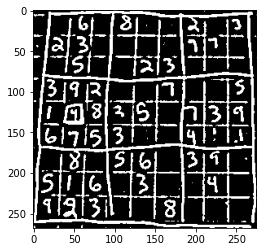

In [ ]:
#@title 
plt.imshow(cropped_polygon_array[0], 'gray')

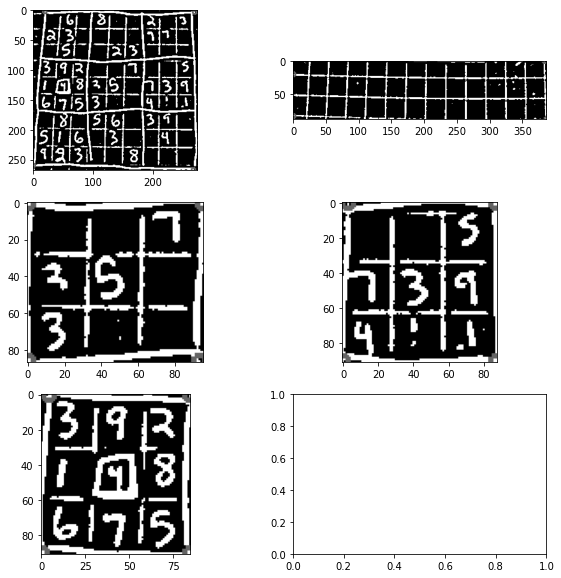

In [ ]:
#@title Processing Table-like Objects
fig, ax = plt.subplots(3, 2, figsize=(10,10))
ax = ax.ravel()
defined_edges = []

for i in range(5):
    cropped_polygon_copy = cropped_polygon_array[i].copy()
    outline, stucture = cv2.findContours(cropped_polygon_copy, 1, 2)
    outline = sorted(outline, key=cv2.contourArea, reverse=True) 
    polygon = np.array(outline[0]).reshape(-1,2) 

    sums_for_bounds = [coord[0] + coord[1] for coord in polygon] 
    differences_for_bounds = [coord[0] - coord[1] for coord in polygon] 

    top_left_corner = np.argmin(sums_for_bounds) 
    bottom_right_corner = np.argmax(sums_for_bounds) 
    bottom_left_corner = np.argmin(differences_for_bounds)
    top_right_corner = np.argmax(differences_for_bounds)

    edges = [tuple(polygon[top_left_corner]), tuple(polygon[top_right_corner]), 
             tuple(polygon[bottom_right_corner]), tuple(polygon[bottom_left_corner])]
    defined_edges.append(edges)

    for edge in edges:
        cv2.circle(cropped_polygon_copy, edge, 3, (100, 100, 255), 2)

    ax[i].imshow(cropped_polygon_copy, 'gray')

In [ ]:
#@title Get Valid Sudoku Table
potential_sudoku = list(range(5))
elements_to_remove = []

for i in range(len(potential_sudoku)):
    if defined_edges[potential_sudoku[i]][0][0] > 50 or defined_edges[potential_sudoku[i]][0][1] > 50: 
        elements_to_remove.append(potential_sudoku[i])

potential_sudoku_table = [j for j in potential_sudoku if j not in elements_to_remove] 

image_area = [coord.shape[0] * coord.shape[1] for coord in cropped_polygon_array] 
max_defined_area = np.max(image_area) 
for k in range(len(potential_sudoku_table)):
    if image_area[potential_sudoku_table[k]] / max_defined_area < 0.5:
        elements_to_remove.append(potential_sudoku_table[k])

sudoku_table = [j for j in potential_sudoku_table if j not in elements_to_remove] 

In [ ]:
#@title 
print('sudoku table: ', sudoku_table)
cropped_polygon_array = [x for idx, x in enumerate(cropped_polygon_array) if idx in sudoku_table]
print('len cropped arr', len(cropped_polygon_array))

sudoku table:  [0]
len cropped arr 1


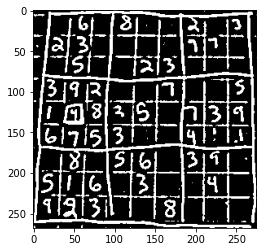

In [ ]:
#@title 
plt.imshow(cropped_polygon_array[0], 'gray')

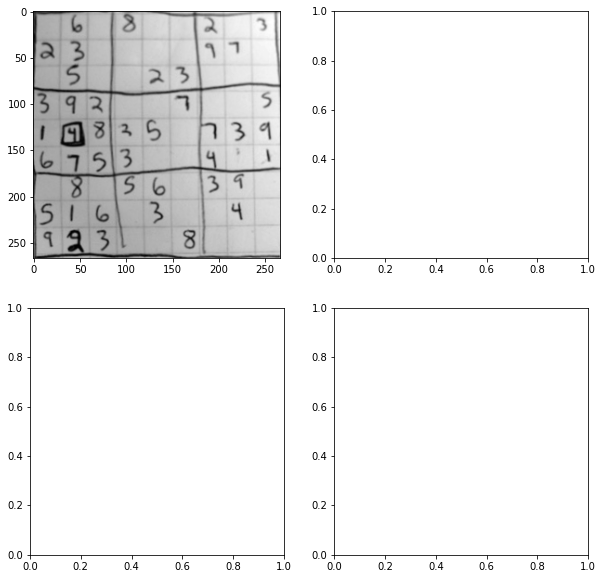

In [ ]:
#@title Table Wrapping 
def euclidean_distance(point_1, point_2):
    x = point_2[0] - point_1[0]
    y = point_2[1] - point_1[1]
    return np.sqrt((x ** 2) + (y ** 2))

matrices = []
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
proccessed_image = []

if len(sudoku_table) == 0:
    sudoku_table.append(0)
    defined_edges = []
    h, w = cropped_polygon_array_original[0].shape
    defined_edges = [[(0,0), (h,0), (h,w), (0,w)],]

for idx, coord in enumerate(sudoku_table): 
    top_left_corner, top_right_corner, bottom_right_corner, bottom_left_corner = defined_edges[coord][0], defined_edges[coord][1], defined_edges[coord][2], defined_edges[coord][3]
    corner = max([euclidean_distance(top_left_corner, top_right_corner), 
                 euclidean_distance(top_right_corner, bottom_right_corner),
                 euclidean_distance(bottom_right_corner, bottom_left_corner),
                 euclidean_distance(bottom_left_corner, top_left_corner),
                ])
    
    pts2 = np.array([[0, 0], [corner - 1, 0], [corner - 1, corner - 1], [0, corner - 1]], dtype='float32')
    
    pts1 = np.float32(defined_edges[coord])

    matrice = cv2.getPerspectiveTransform(pts1, pts2)
    matrices.append(matrice)

    dst = cv2.warpPerspective(cropped_polygon_array_original[idx], matrice, (int(corner), int(corner)))
    proccessed_image.append(dst)
    ax[idx].imshow(dst, 'gray')

In [ ]:
#@title Final Image Processing As a Whole
finally_processed_image = []
for i in range(len(proccessed_image)):
    proccessed = proccessed_image[i].copy()
    proccessed = cv2.GaussianBlur(proccessed, (9, 9), 0)
    proccessed = cv2.adaptiveThreshold(proccessed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    proccessed = cv2.bitwise_not(proccessed, proccessed)
    finally_processed_image.append(proccessed)

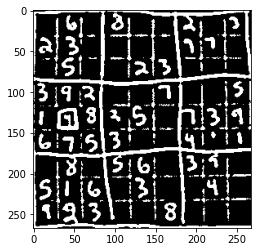

In [ ]:
#@title 
plt.imshow(finally_processed_image[0], 'gray')

In [ ]:
#@title Parts Of Sudoku Processing Functions
def define_bounding_box(input, corner_top_left, corner_bottom_right):
    image = input.copy()
    h, w = image.shape

    max_defined_area = 0
    seed = (None, None)

    for x in range(corner_top_left[0], corner_bottom_right[0]):
        for y in range(corner_top_left[1], corner_bottom_right[1]):
            if image.item(y, x) == 255 and x < w and y < h:  
                area = cv2.floodFill(image, None, (x, y), 64)
                if area[0] > max_defined_area:  
                    max_defined_area = area[0]
                    seed = (x, y)

    for x in range(w):
        for y in range(h):
            if image.item(y, x) == 255 and x < w and y < h:
                cv2.floodFill(image, None, (x, y), 64)

    mask = np.zeros((h + 2, w + 2), np.uint8) 

    if all([c is not None for c in seed]):
        cv2.floodFill(image, mask, seed, 255)

    top, bottom, left, right = h, 0, w, 0
    
    for x in range(w):
        for y in range(h):
            if image.item(y, x) == 64: 
                cv2.floodFill(image, mask, (x, y), 0)
            
            if image.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right

    return left, top, right, bottom

def scaling(image, size, margin=0, background=0):
	h, w = image.shape[:2]

	def centre_padding_inner(length):
		if length % 2 == 0:
			side_1 = int((size - length) / 2)
			side_2 = side_1
		else:
			side_1 = int((size - length) / 2)
			side_2 = side_1 + 1
		return side_1, side_2

	def scale_inner(r, x):
		return int(r * x)

	if h > w:
		top_padding = int(margin / 2)
		bottom_padding = top_padding
		ratio = (size - margin) / h
		w, h = scale_inner(ratio, w), scale_inner(ratio, h)
		left_padding, right_padding = centre_padding_inner(w)
	else:
		left_padding = int(margin / 2)
		right_padding = left_padding
		ratio = (size - margin) / w
		w, h = scale_inner(ratio, w), scale_inner(ratio, h)
		top_padding, bottom_padding = centre_padding_inner(h)

	image = cv2.resize(image, (w, h))
	image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, None, background)
	return cv2.resize(image, (size, size))

In [ ]:
#@title Sudoku Cells Processing
table_general = []
coordinates = {}
for table in finally_processed_image:
    side_length = table.shape[0] / 9
    dop = []
    for i in range(9):
        left_c = int(i * side_length)
        for j in range(9):
            right_c = int(j * side_length)
            current_bound_box = table[left_c:int(left_c + side_length), right_c:int(right_c + side_length)]
            
            margin = int(current_bound_box.shape[0] / 2.5)    
            left, top, right, bottom = define_bounding_box(current_bound_box, [margin, margin], 
                                                         [current_bound_box.shape[0] - margin, current_bound_box.shape[1] - margin]) 
            coordinates[(i, j)] = (left_c + margin, right_c + margin)
            if left == top and right == bottom:
                current_bound_box = np.zeros((28,28))
            else:
                current_bound_box = current_bound_box[top:bottom + 2, left:right + 2] 
                current_bound_box = scaling(current_bound_box, 28, 4)
                current_bound_box = cv2.threshold(current_bound_box, 80, 255, cv2.THRESH_BINARY)[1]
            dop.append(current_bound_box)            
    table_general.append(dop)
    
table_general = np.array(table_general)

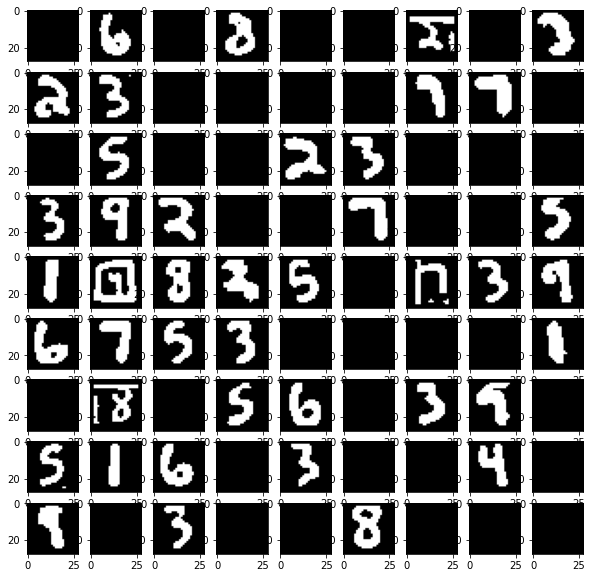

In [ ]:
#@title 
fig, ax =  plt.subplots(9,9, figsize=(10,10))
ax = ax.ravel()

for idx in range(81):    
    ax[idx].imshow(table_general[0][idx], 'gray')

In [ ]:
model = tf.keras.models.load_model('model_better.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1600)              6

In [ ]:
#@title Sudoku Digit Prediction
sudoku_array_table = []

for i in range(table_general.shape[0]):
    dop = []
    for j in range(table_general.shape[1]):
        if len(np.where(table_general[i][j][7:17, 7:17].ravel() == 0)[0])/100 > 0.9:
            dop.append('0')
        else:
            current_b_box = table_general[i][j].reshape(1,28,28,1) / 255
            y_pred = np.argmax(model.predict(current_b_box), axis=-1)[0]
            if y_pred == 0:
                current_prediction = model.predict(current_b_box).ravel()
                maxs_idx = current_prediction.argsort()[-2:]
                y_pred = maxs_idx[0]
            dop.append(y_pred)
            
    sudoku_array_table.append(dop)

In [ ]:
#@title 
np.array(sudoku_array_table[0]).reshape(9,9)

array([['0', '6', '0', '8', '0', '0', '5', '0', '3'],
       ['2', '3', '0', '0', '0', '0', '7', '7', '0'],
       ['0', '5', '0', '0', '2', '3', '0', '0', '0'],
       ['3', '9', '2', '0', '0', '0', '0', '0', '7'],
       ['1', '9', '8', '4', '5', '0', '9', '3', '9'],
       ['6', '7', '9', '3', '0', '0', '0', '0', '1'],
       ['0', '8', '0', '5', '6', '0', '3', '9', '0'],
       ['5', '1', '6', '0', '3', '0', '0', '9', '0'],
       ['1', '0', '3', '0', '0', '8', '0', '0', '0']], dtype='<U1')

In [ ]:
#@title Processing Before Giving Hints
sudoku_array_table = np.array(sudoku_array_table[0]).reshape(9,9).tolist()
myBoard = []
for el in sudoku_array_table:
  myBoard.append([int(i) for i in el])

import copy
init_board = copy.deepcopy(myBoard)
sub_board = copy.deepcopy(myBoard)

There are duplicate numbers in column!
I want to fix it
[[6, 5], [1, 5]]


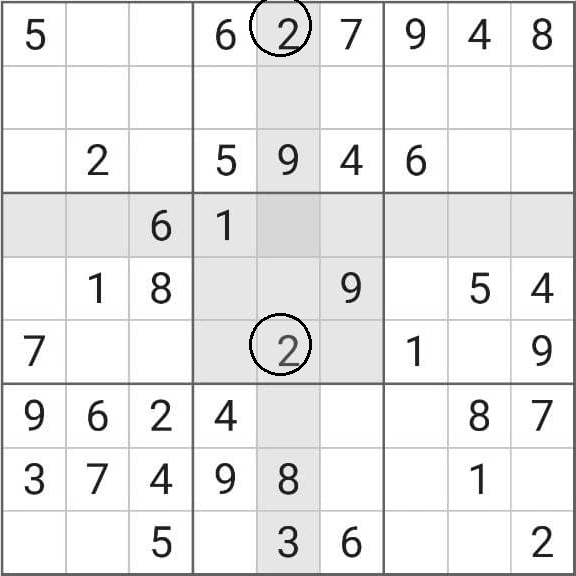

[5, 0, 0, 6, 0, 7, 9, 4, 8]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 2, 0, 5, 9, 4, 6, 0, 0]
[0, 0, 6, 1, 0, 0, 0, 0, 0]
[0, 1, 8, 0, 0, 9, 0, 5, 4]
[7, 0, 0, 0, 0, 0, 1, 0, 9]
[9, 6, 2, 4, 0, 0, 0, 8, 7]
[3, 7, 4, 9, 8, 0, 0, 1, 0]
[0, 0, 5, 0, 3, 6, 0, 0, 2]


In [ ]:
#@title Sudoku Validation

from google.colab.patches import cv2_imshow
def valid_row(row, grid, fix):
    list=[]
    temp = grid[row]
    # Checking for invalid values.
    for i in range(len(temp)):
        if (temp[i] < 0 or temp[i] > 9):
            if fix==True:
                myBoard[row][i]=0
            if fix==False:
                return -1
    # Checking for repeated values.
        check_list = temp.copy()
        check_list[i] = 0
        if (temp[i] in check_list) and (temp[i]!=0):
            if fix==True:
                myBoard[row][check_list.index(temp[i])]=0
                list.append([row+1,check_list.index(temp[i])+1])
            if fix==False:
                return 0
    return list


def valid_col(col, grid, fix):
    list = []
    # Extracting the column.
    temp = [row[col] for row in grid]
    # Checking for repeated values.
    for i in range(len(temp)):
        check_list = temp.copy()
        check_list[i] = 0
        if (temp[i] in check_list) and (temp[i] != 0):
            if fix == True:
                myBoard[check_list.index(temp[i])][col] = 0
                list.append([check_list.index(temp[i])+1, col+1])
            if fix == False:
                return 0
    return list


def valid_subsquares(grid, fix):
    list = []
    for row in range(0, 9, 3):
        for col in range(0, 9, 3):
            temp = []
            for r in range(row, row + 3):
                for c in range(col, col + 3):
                    if (grid[r][c]!=0) and (grid[r][c] in temp):
                        if fix == True:
                            myBoard[r][c] = 0
                            list.append([r,c])
                        if fix == False:
                            return 0
                        temp.append(0)
                    else:
                        temp.append(grid[r][c])
    return list


def valid_board(grid):
    list=[]
    for i in range(9):
        res1 = valid_row(i, grid, False)
        if (res1 == 0):
            print("There are duplicate numbers in row!")
            print("I want to fix it")
            list.append(valid_row(i, grid, True))
        if (res1 ==-1):
            print("Invalid value")
            print("I want to fix it")
            valid_row(i, grid, True)
    for i in range(9):
        res2 = valid_col(i, grid, False)
        if (res2 == 0):
            print("There are duplicate numbers in column!")
            print("I want to fix it")
            list.append(valid_col(i, grid, True))
    res3 = valid_subsquares(grid, False)
    if (res3 == 0):
        print("There are duplicate numbers in subsquare!")
        list.append(valid_subsquares(grid, True))
       #return False
    return list

input = valid_board(myBoard)
x_y_values = [elem for twod in input for elem in twod]
print(x_y_values)
image_for_painting = cropped_polygon_array_original[0].copy()
for coor in x_y_values:
  cv2.circle(image_for_painting, coordinates[(coor[1]-1, coor[0]-1)], (30), (0,0,255), 2)
cv2_imshow(image_for_painting)

for l in myBoard:
    print(l)

You can put 3 in a cell with coordinates (1,2)


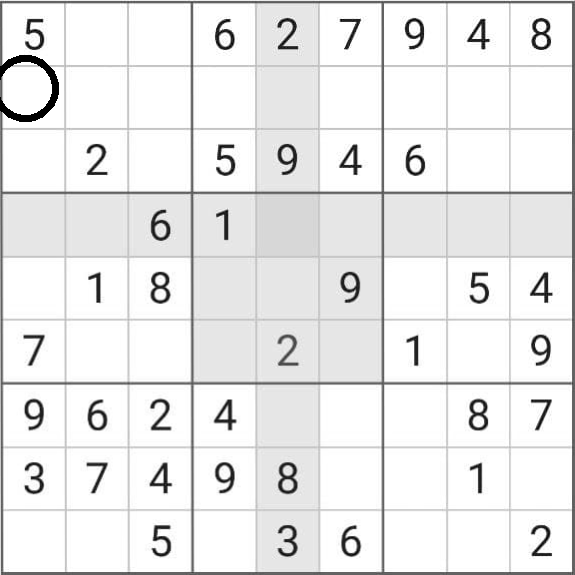

---------------------------------------
[5, 3, 1, 6, 2, 7, 9, 4, 8]
[6, 4, 9, 8, 1, 3, 2, 7, 5]
[8, 2, 7, 5, 9, 4, 6, 3, 1]
[4, 9, 6, 1, 7, 5, 8, 2, 3]
[2, 1, 8, 3, 6, 9, 7, 5, 4]
[7, 5, 3, 2, 4, 8, 1, 6, 9]
[9, 6, 2, 4, 5, 1, 3, 8, 7]
[3, 7, 4, 9, 8, 2, 5, 1, 6]
[1, 8, 5, 7, 3, 6, 4, 9, 2]


In [ ]:
#@title Sudoku Hints { form-width: "10px" }
from google.colab.patches import cv2_imshow
def isValid(board, row, col, num):
        # check row
    for i in range(9):
        if board[row][i] == num:
            return False

        # check col
    for i in range(9):
        if board[i][col] == num:
            return False

        # get top-left corner
    c_row = row - row % 3
    c_col = col - col % 3

        # check 3x3 square
    for i in range(c_row, c_row + 3):
        for j in range(c_col, c_col + 3):
            if board[i][j] == num:
                return False

        # return True if none of the cases above returns False
    return True



def solveBoard(board):
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:
                for num in range(1, 10):
                    if isValid(board, i, j, num):
                        board[i][j] = num
                        result = solveBoard(board)
                        if result == True:
                            return True
                        else:
                            board[i][j] = 0
                return False
    return True


def change_values(myBoard, init_board, sub_board):
    if init_board==myBoard:
        print('There are no solutions')
        for i in range(len(myBoard[0][:])):
            for j in range(len(myBoard[:][0])):
                if myBoard[i][j] != 0:
                    myBoard[i][j] = 0
                    sub_board[i][j] = 0
                    if solveBoard(myBoard)==True:
                        print_possible_changes(myBoard, init_board, sub_board)
                        return

def print_hint(myBoard, init_board):
    for i in range(len(myBoard[0][:])):
        for j in range(len(myBoard[:][0])):
            if init_board[i][j] == 0:
                print("You can put {} in a cell with coordinates ({},{})".format(myBoard[i][j], i+1, j+1))
                list_x_y = [i+1,j+1]
                return list_x_y

def print_possible_changes(myBoard, init_board, sub_board):
    list_x_y = []
    for i in range(len(myBoard[0][:])):
        for j in range(len(myBoard[:][0])):
            if init_board[i][j] != sub_board[i][j] and myBoard[i][j]!=init_board[i][j]:
                print("You must change value to {} in a cell with coordinates ({},{})".format(myBoard[i][j], i+1, j+1))
                list_x_y.append([i+1,j+1])
    return list_x_y

if solveBoard(myBoard) == False:
    list_one = change_values(myBoard, init_board, sub_board)
    print(list_one)
else:
    list_two = print_hint(myBoard, init_board)
    image_for_painting = proccessed_image[0].copy()
    cv2.circle(image_for_painting, coordinates[(list_two[0]-1, list_two[1]-1)], (30), (0,0,255), 5)
    cv2_imshow(image_for_painting)
print('---------------------------------------')
for l in myBoard:
    print(l)